# Figure 15: comparing to Jansen 2008
## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
import numpy as np
import pylab as plt
import matplotlib

import importlib
import Rate_transitions
import Finding_dictionary_keys
import Prob_absorb_to_each
import Time_absorb_wild_states
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
find_keys = Finding_dictionary_keys.find_keys
prob_reach_absorb = Prob_absorb_to_each.prob_reach_absorb_Hughes
F = Hughes_model.F_hughes
absorb_time_wolb = Time_absorb_wild_states.absorb_time_wolb_Hughes
absorb_time_ext = Time_absorb_wild_states.absorb_time_ext

Parameter values

In [2]:
# parameters

K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 85/100    # Wolbachia fitness

v = 10/10     # probability of vertical transmission
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k,K),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Functions to compute invasion probability from Jansen 2008.

In [3]:
def compute_theta(N, x):
    ''' compute theta_i - the rate of Wolbachia-infected mosquito reproduction and theta_u - the
    rate of wildtype mosquito reproduction, given N total mosquitoes and x Wolbachia-infected mosquitoes.'''
    theta_i = v*phi*x
    theta_u = ((N-x)/N)*(N-x + (1-v)*phi*x) + (x/N)*((1-u)*(N-x) + (1-v)*phi*x)
    return theta_i, theta_u  # return theta_i, theta_u

def compute_prod(N, j):
    ''' Compute the product term in the formula for the invasion probability, see Jansen 2008.'''
    prod = 1
    for i in range(1,j+1):
        theta_i, theta_u = compute_theta(N, i)
        prod *= i*theta_u/((N-i)*theta_i)
    return prod  # return the product term

def compute_inv_prob(N, x):
    ''' Compute the invasion probability of Wolbachia, given N total mosquitoes and x
    Wolbachia-infected mosquitoes. See equation (A3) in Jansen 2008.'''
    sum_top = 0
    sum_bottom = 0
    for j in range(x):
        sum_top += compute_prod(N, j)  # summing over the products in the numerator
    for j in range(N):
        sum_bottom += compute_prod(N, j)  # summing over the products in the denominator
    return sum_top/sum_bottom   # return the invasion probability

Compute invasion probability from Jansen 2008 model

In [4]:
N_values = [30, 10]  # total mosquito population sizes to consider

for N in N_values:  # loop over total population sizes
    inv_prob_vec = np.array([compute_inv_prob(N, inf) for inf in range(N+1)]) # compute invasion probabilities
    init_inf_prop = np.arange(N+1) / N  # initial proportion of Wolbachia-infected mosquitoes
    if N == 30:  # store results for N=30
        inv_prob_vec30 = inv_prob_vec
        init_inf_prop30 = init_inf_prop
    else:  # store results for N=10
        inv_prob_vec = inv_prob_vec
        init_inf_prop = init_inf_prop

Calculate invasion probability from our model

In [5]:
def compute_inv_prob_AB(N, K, params_dict):
    ''' Compute the invasion probability of Wolbachia, given N total mosquitoes and K
    is the maximum population size using the methods set out in Barlow 2025.'''
    max_pop = K  # maximum population size
    # create full state and transient state dictionaries
    state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate(
        [(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
    trans_dict = {index: np.array((i, j)) for index, (i, j) in enumerate(
        [(i, j) for i in range(1, max_pop + 1) for j in range(1, max_pop + 1) if i + j <= max_pop])}

    n_transient = len(trans_dict)  # number of transient states
    prob_reach_wolb = np.zeros(n_transient)  # initialize probability vector
    for i in range(max_pop):  # loop over absorbing states
        absorb_state = np.array([0, i + 1])  # absorbing state with i+1 Wolbachia-infected mosquitoes
        # compute probability of reaching absorbing state from each transient state
        # add to total probability of reaching any absorbing state with Wolbachia
        prob_reach_wolb[:] += np.transpose(
            prob_reach_absorb(state_dict, trans_dict, absorb_state, params_dict)[0]
        )[0]

    inv_prob_vec_AB = np.zeros(N + 1)  # initialize invasion probability vector
    init_inf_prop_AB = np.zeros(N + 1) # initialize initial infection proportion vector
    ct = 1  # counter for filling in invasion probability vector
    for k in range(n_transient):  # loop over transient states
        indx1, indx2 = trans_dict[k]  # get transient state (indx1, indx2)
        if indx1 + indx2 == N:  # check if total population size is N
            inv_prob_vec_AB[N - ct] = prob_reach_wolb[k]  # fill in invasion probability vector
            init_inf_prop_AB[N - ct] = indx2 / N  # fill in initial infection proportion vector
            ct += 1  # increment counter

    inv_prob_vec_AB[N] = 1  # invasion probability is 1 if all mosquitoes are infected
    init_inf_prop_AB[N] = 1
    return inv_prob_vec_AB, init_inf_prop_AB  # return invasion probability and initial infection proportion vectors

# Usage for both N=30 and N=10
inv_prob_vec_AB30, init_inf_prop_AB30 = compute_inv_prob_AB(30, K, params_dict)
inv_prob_vec_AB, init_inf_prop_AB = compute_inv_prob_AB(10, K, params_dict)

Produce figure

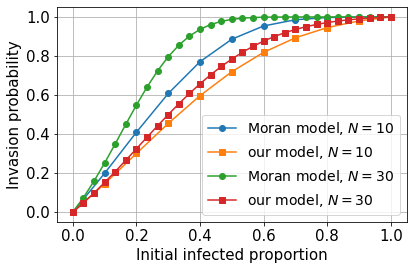

In [7]:
matplotlib.rcParams.update({'font.size': 15})   # font size
plt.plot(init_inf_prop, inv_prob_vec, marker='o', label = r'Moran model, $N=10$')
plt.plot(init_inf_prop_AB, inv_prob_vec_AB, marker='s', label = r'our model, $N=10$')
plt.plot(init_inf_prop30, inv_prob_vec30, marker='o', label = r'Moran model, $N=30$')
plt.plot(init_inf_prop_AB30, inv_prob_vec_AB30, marker='s', label = r'our model, $N=30$')
plt.grid() 
plt.xlabel('Initial infected proportion')
plt.ylabel('Invasion probability')
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('comparison_Jansen.pdf', bbox_inches='tight')

In [ ]:
N = 30
max_pop = K  # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
trans_dict = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

n_transient = len(trans_dict)            # number of transient states i.e. mixed
prob_reach_wolb = np.zeros(n_transient)  # initialise an array to hold all the probabilities for the mixed states
for i in range(max_pop):                 # looping over the Wolbachia-only state space
    absorb_state = np.array([0,i+1])     # current Wolbachia-only state (absorbing state)
    # adding the probability of reaching that state from each initial mixed state to the probabilities array
    prob_reach_wolb[:] += np.transpose(prob_reach_absorb(state_dict,trans_dict,absorb_state,params_dict)[0])[0]

ct = 1
inv_prob_vec_AB30 = np.zeros(N+1)    # initialise an array to hold the invasion probabilities
init_inf_prop_AB30 = np.zeros(N+1)   # initialise an array to hold the
for k in range(n_transient):         # looping over all the mixed/ transient states
    # setting the index of the current invasion probability corresponding to the intial state
    indx1, indx2 = trans_dict[k]
    if indx1 + indx2 == N:
        inv_prob_vec_AB30[N-ct] = prob_reach_wolb[k]  # recording the probability
        init_inf_prop_AB30[N-ct] = indx2/N           # recording the initial infected proportion
        ct += 1

inv_prob_vec_AB30[N] = 1  # if all are infected, invasion probability is 1
init_inf_prop_AB30[N] = 1  # if all are infected, initial infected proportion is 1

In [ ]:
N = 10
max_pop = K  # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
trans_dict = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

n_transient = len(trans_dict)            # number of transient states i.e. mixed
prob_reach_wolb = np.zeros(n_transient)  # initialise an array to hold all the probabilities for the mixed states
for i in range(max_pop):                 # looping over the Wolbachia-only state space
    absorb_state = np.array([0,i+1])     # current Wolbachia-only state (absorbing state)
    # adding the probability of reaching that state from each initial mixed state to the probabilities array
    prob_reach_wolb[:] += np.transpose(prob_reach_absorb(state_dict,trans_dict,absorb_state,params_dict)[0])[0]

ct = 1
inv_prob_vec_AB = np.zeros(N+1)    # initialise an array to hold the invasion probabilities
init_inf_prop_AB = np.zeros(N+1)   # initialise an array to hold the
for k in range(n_transient):         # looping over all the mixed/ transient states
    # setting the index of the current invasion probability corresponding to the intial state
    indx1, indx2 = trans_dict[k]
    if indx1 + indx2 == N:
        inv_prob_vec_AB[N-ct] = prob_reach_wolb[k]  # recording the probability
        init_inf_prop_AB[N-ct] = indx2/N           # recording the initial infected proportion
        ct += 1

inv_prob_vec_AB[N] = 1  # if all are infected, invasion probability is 1
init_inf_prop_AB[N] = 1  # if all are infected, initial infected proportion is 1